# In-vitro data

## Imports

In [53]:
%reload_ext autoreload
%reload_ext jupyter_black
%autoreload 2

In [54]:
import pandas as pd
import numpy as np
import plotnine as p9
from Levenshtein import distance
from sklearn.metrics import roc_curve

In [55]:
double_split = pd.read_csv("input/invitro-double-split.csv", index_col=0)

In [56]:
def replicate_table(
    df: pd.DataFrame, exclude_plates: list = (), annotation: dict = {}
) -> pd.DataFrame:
    dd = (
        df[["plate_name", "sequence", "objectid", "team", "output"]]
        .loc[lambda d: ~d.plate_name.isin(list(exclude_plates))]
        .drop(columns=["plate_name"])
        .drop_duplicates(subset=["sequence", "team", "objectid"])
        .merge(double_split, how="left")
        .drop(columns=["objectid"])
        .groupby(["sequence", "team", "split", "same_plate"])
        .mean(numeric_only=True)
        .reset_index()
        .set_index(["sequence", "same_plate", "team", "split"])
        .unstack()
        .reset_index()
        .assign(**annotation)
    )
    dd.columns = [a if b == "" else b for a, b in dd.columns]
    return dd

In [57]:
ref = "LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD"

In [58]:
team_names = {
    "bcr": "AI4PD",
    "bcr-ai4pd": "AI4PD",
    "exazyme": "Exazyme",
    "nimbus": "Nimbus",
    "tum": "TUM Rostlab",
    "tum-rostlab": "TUM Rostlab",
    "marks": "Marks Lab",
    "marks-lab": "Marks Lab",
    "MediumBio-Baseline": "MediumBio",
}

## Plots

- Get rid of the Q948 repeat plate - was not better

In [59]:
adf = pd.read_csv("output/invitro-all.csv.gz", index_col=0).loc[
    lambda d: d.plate_name != "AMYE-Q948_R"
]

### Data quality

- Remove Q948 from expression and activity since not representative

In [60]:
qc_expression = (
    replicate_table(
        adf.query("target == 'expression'").query("plate_name != 'AMYE-Q948'"),
    )
    .dropna()
    .assign(target="expression")
)
qc_activity = (
    replicate_table(
        adf.query("target == 'specific_activity'").query("plate_name != 'AMYE-Q948'"),
    )
    .dropna()
    .assign(target="specific_activity")
)
qc_stability = (
    replicate_table(
        adf.query("target == 'stability'"),
    )
    .dropna()
    .assign(target="stability")
)
qc = pd.concat([qc_expression, qc_activity, qc_stability])

In [61]:
ann = (
    qc[["target", "s0", "s1"]]
    .groupby("target", as_index=False)
    .apply(
        lambda d: pd.DataFrame(
            {
                "s0": [d.s0.min()],
                "s1": [d.s1.max() * 0.95],
                "target": d.target.iat[0],
            }
        ),
    )
    .reset_index(drop=True)
)

/var/folders/kr/04pmmtp555vg9xcspkt2lldr0000gn/T/ipykernel_60279/1308888710.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [62]:
cc = (
    qc.drop(columns=["same_plate"])
    .groupby("target")
    .corr(method="spearman", numeric_only=True)
    .loc[(slice(None), "s0"), ["s1"]]
    .reset_index(level=1, drop=True)
    .reset_index()
    .rename(columns={"s1": "spearman"})
    .round(decimals=2)
    .assign(spearman=lambda d: [f"Spearman: {x}" for x in d.spearman])
    .merge(ann)
)

In [63]:
for d in (cc, qc):
    for t in ["expression", "specific_activity", "stability"]:
        d["target"] = d.target.str.title().str.replace("_", " ")

Assay reproducibility was sufficient for the main target of interest: specific activity. Where possible, we picked two sequence verified cloned for each of the submitted variants. We then produced enzyme from all clones and measured expression levels, the specific activity and temperature stability. The two clones formed were randomly allocated the designation Replicate A and Replicate B and plotted against each other to illustrate the assay noise. Expression and specific activity estimates had good reproducibility. Noise was considerably higher in the stability assay but it was still deemed good enough for an approximate indication of stability.

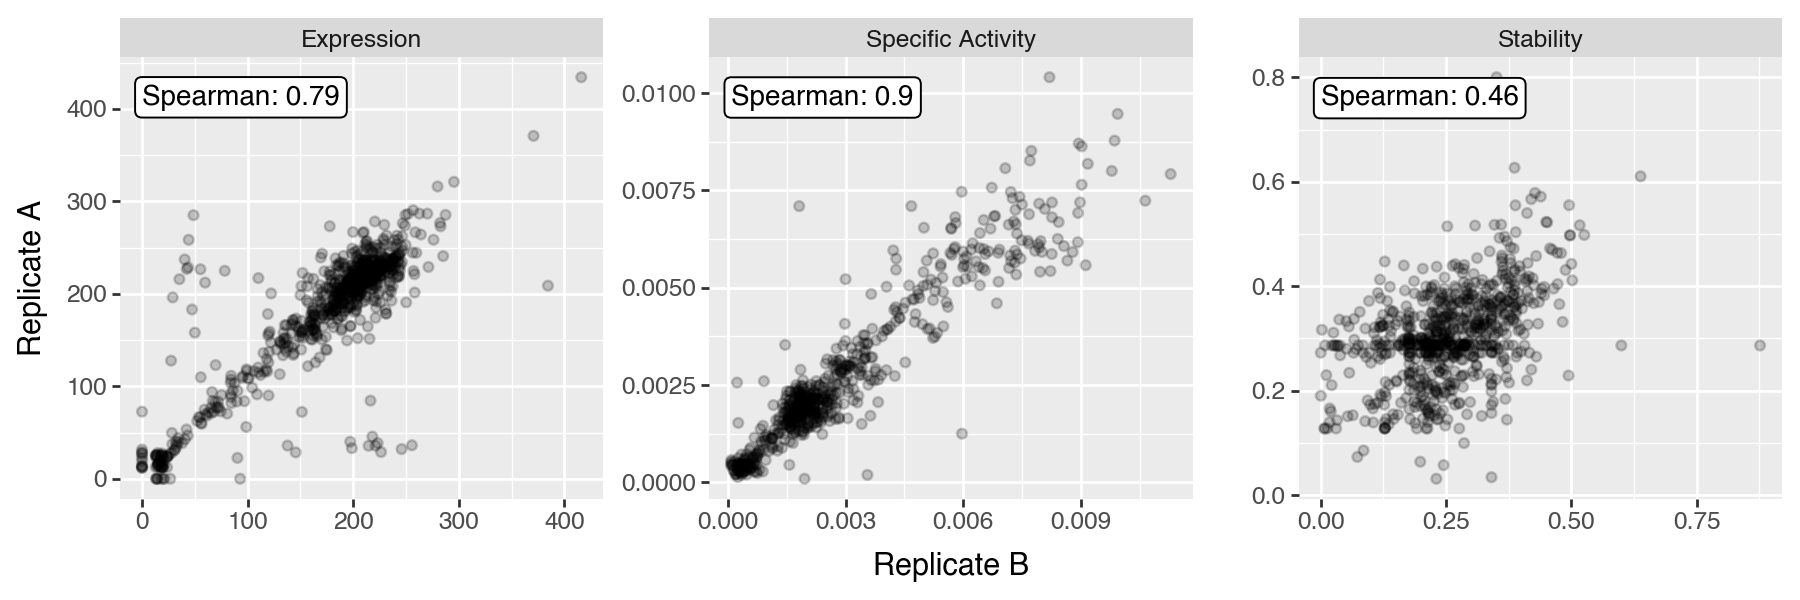

In [64]:
p9.options.set_option("figure_size", (9, 3))
p1 = (
    p9.ggplot(qc, p9.aes("s0", "s1"))
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ target", scales="free")
    + p9.ylab("Replicate A")
    + p9.xlab("Replicate B")
    + p9.geom_label(data=cc, mapping=p9.aes(label="spearman"), size=10, ha="left")
)
p1

In [65]:
p1.draw(show=False).savefig("../doc/in-vitro-qc-plot.png", dpi=150)

### Winners in individual targets

In [66]:
adf = pd.read_csv("output/invitro-all.csv.gz", index_col=0).loc[
    lambda d: d.plate_name != "AMYE-Q948_R"
]

We summarize the two replicats like this
- For expression, activity: if one replicate on plate Q948, take the other replicate. Otherwise average.
- For stability: take the highest residual activity


In [67]:
expression = (
    adf.query("target == 'expression'")
    .groupby(["team", "sequence"], as_index=False)
    .apply(
        lambda d: (
            d.output.mean()
            if (d.plate_name == "AMYE-Q948").all()
            else d.query("plate_name != 'AMYE-Q948'").output.mean()
        ),
        include_groups=False,
    )
    .rename(columns={None: "output"})
    .assign(target="expression")
)

In [68]:
specific_activity = (
    adf.query("target == 'specific_activity'")
    .groupby(["team", "sequence"], as_index=False)
    .apply(
        lambda d: (
            d.output.mean()
            if (d.plate_name == "AMYE-Q948").all()
            else d.query("plate_name != 'AMYE-Q948'").output.mean()
        ),
        include_groups=False,
    )
    .rename(columns={None: "output"})
    .assign(target="specific_activity")
)

In [69]:
stability = (
    adf.query("target == 'stability'")
    .groupby(["team", "sequence"], as_index=False)
    .max()
)[["team", "sequence", "output"]].assign(target="stability")

In [70]:
summ = (
    pd.concat([expression, specific_activity, stability])
    .assign(
        team=lambda d: d.team.replace(team_names),
        target=lambda d: d.target.str.replace("_", " ").str.title(),
    )
    .assign(
        target=lambda d: pd.Categorical(
            d.target, categories=["Expression", "Stability", "Specific Activity"]
        )
    )
)

Different teams excelled at the different targets. The measurements for the two replicates were averaged and visualized across the different teams. All submitted variants expressed markedly worse than the reference molecule and no team outperform the others. In stability, MediumBio's variants were overall better than the other teams. For specific activity, the main target of interest, TUM was the clear winner. The level of the reference molecule is indicated by the solid black line.

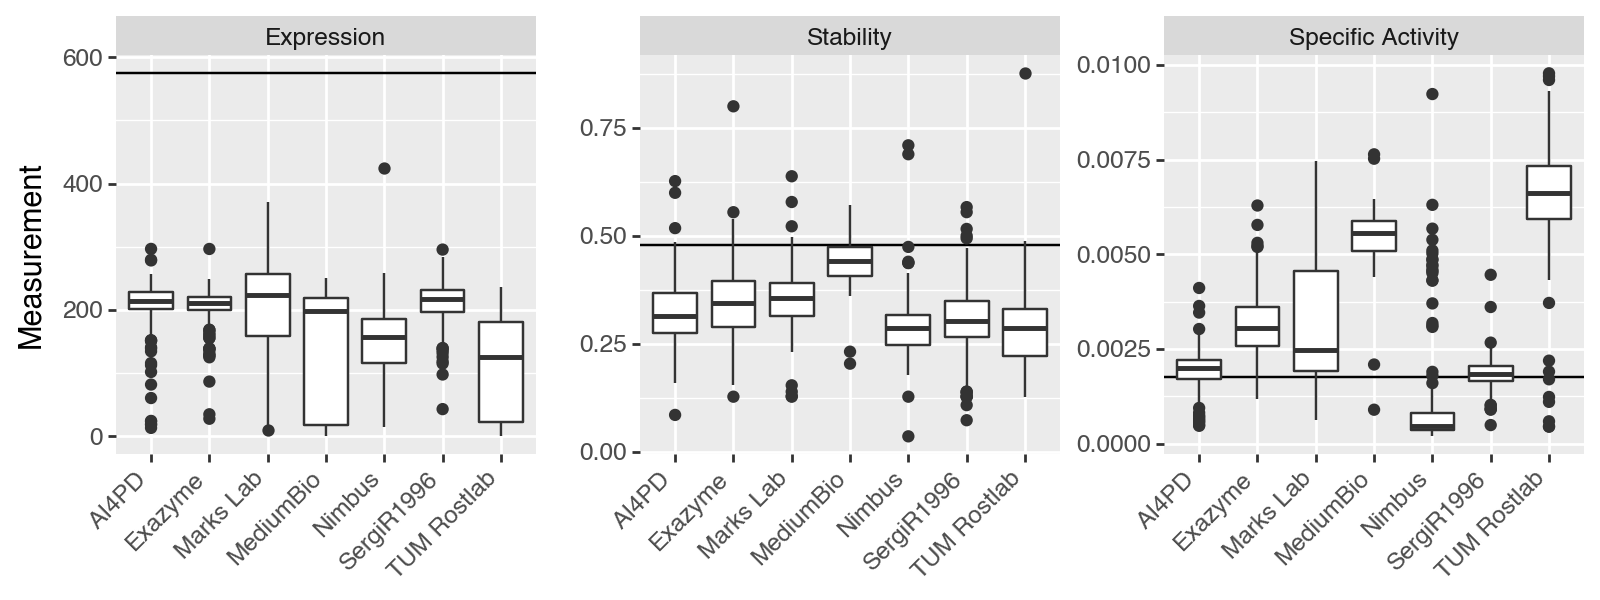

In [71]:
p9.options.set_option("figure_size", (8, 3))
p2 = (
    p9.ggplot(summ.loc[lambda d: d.team != "control"], p9.aes("team", "output"))
    + p9.geom_hline(
        mapping=p9.aes(yintercept="output"),
        data=summ.loc[lambda d: d.team == "control"],
    )
    + p9.geom_boxplot()
    + p9.facet_wrap("~target", scales="free")
    + p9.theme(
        axis_text_x=p9.element_text(angle=45, ha="right"),
    )
    + p9.ylab("Measurement")
    + p9.xlab("")
)
p2

In [72]:
p2.draw(show=False).savefig("../doc/invitro-ndividual-performance-plot.png", dpi=150)

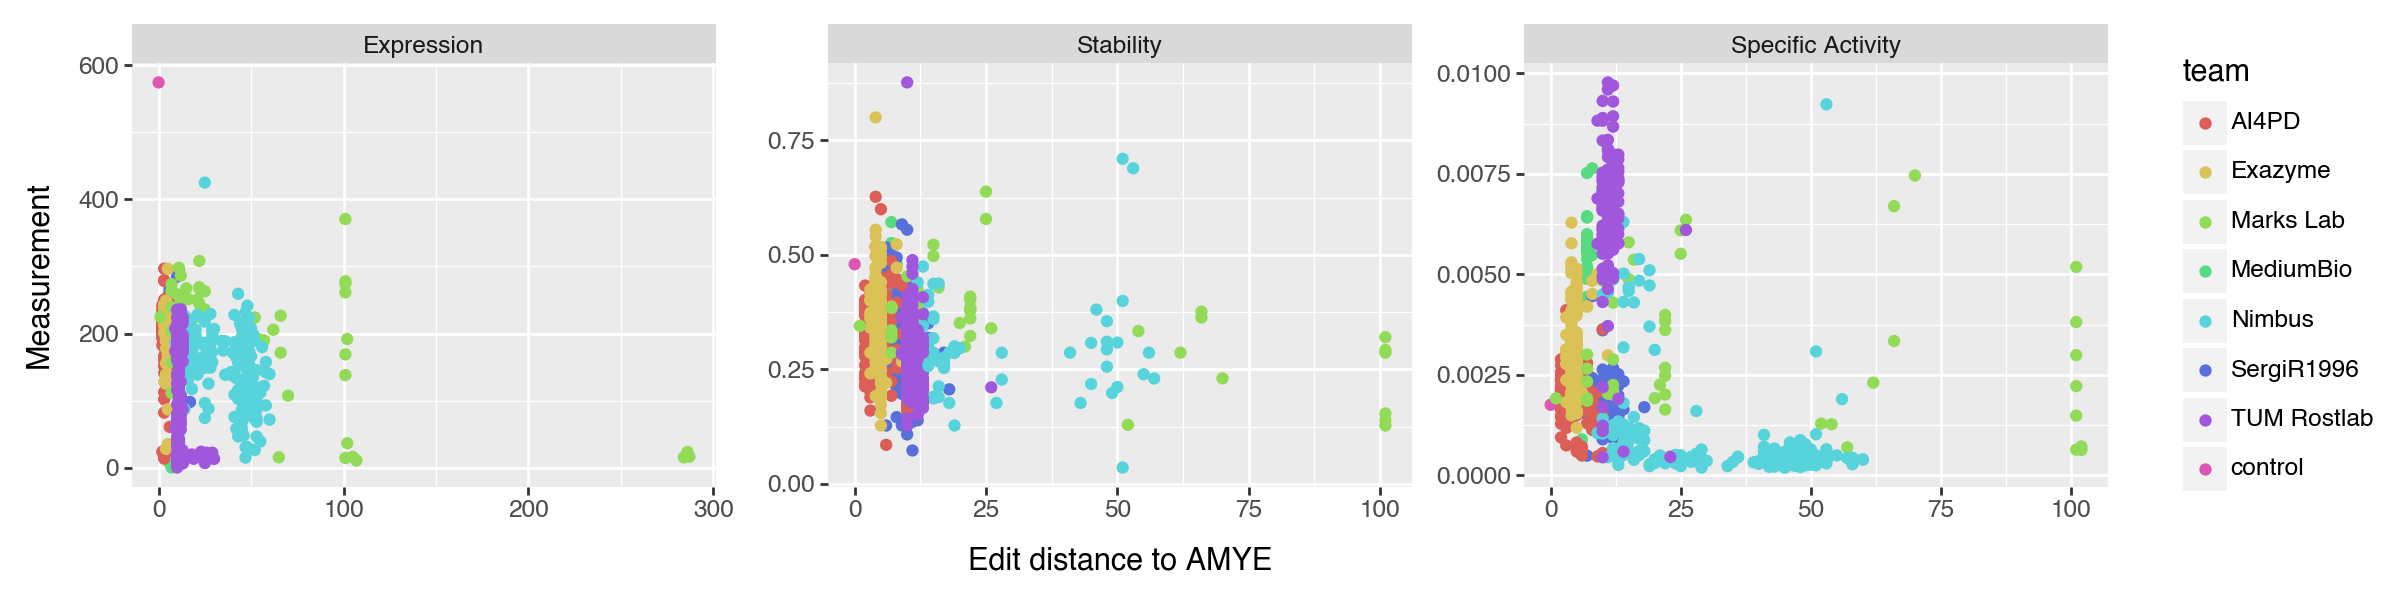

In [73]:
dist = summ.assign(distance=lambda d: d.sequence.apply(lambda s: distance(s, ref)))
p9.options.set_option("figure_size", (12, 3))
p3 = (
    p9.ggplot(
        dist,
        p9.aes("distance", "output", color="team"),
    )
    + p9.geom_point()
    + p9.facet_wrap("~ target", scales="free")
    + p9.ylab("Measurement")
    + p9.xlab("Edit distance to AMYE")
)
p3

In [74]:
p3.draw(show=False).savefig("output/distance-measurement-plot.png", dpi=150)

### Winner 

Expression > 0.3 * wt
Stabilty > 0.75 * wt
Max activity

In [75]:
expression_limit = (expression.query("team == 'control'").output * 0.3).iat[0]
stability_limit = (stability.query("team == 'control'").output * 0.75).iat[0]

In [76]:
expression_ok = expression.loc[lambda d: d.output >= expression_limit].sequence.values
stability_ok = stability.loc[lambda d: d.output > stability_limit].sequence.values
both_ok = set(expression_ok) & set(stability_ok)

In [77]:
eligibility = {}
for seq in specific_activity.sequence.values:
    if seq not in expression_ok and seq not in stability_ok:
        eligibility[seq] = "Low Expr / Low Stab"
    elif seq not in expression_ok:
        eligibility[seq] = "Low Expression"
    elif seq not in stability_ok:
        eligibility[seq] = "Low Stability"
    else:
        eligibility[seq] = "Pass"

In [78]:
dd = specific_activity.assign(Category=lambda d: d.sequence.map(eligibility)).assign(
    team=lambda d: d.team.replace(team_names),
    target=lambda d: d.target.str.replace("_", " ").str.title(),
)

In [79]:
team_order = list(
    dd.query("Category == 'Pass'")
    .groupby("team")
    .max()
    .output.sort_values(ascending=False)
    .index.values
)

In [80]:
dd = dd.assign(team=lambda d: pd.Categorical(d.team, categories=team_order))

TUM wins the in-vitro track of the pilot edition Protein Engineering Tournament. The goal of the challenge was to propose a variant that had as high specific activity as possible under the constraint that expression and stability was not worse than the control molecule. No variant met this expression criteria so for the sake of still being able to announce a team ranking, we relaxed that threshold to 30% of the control expression level. Several variants were as stable as the control. However, the stability assay had low reproducibility and we therefore relaxed that criteria as well to 75% of the control. All variants were categorized as too low expression, too low stability, a combination thereof of pass if they met all criteria. All teams were successful at proposing variants with improved successful activity but TUM had the best population as well as the highest individual scoring variant.

In [81]:
cont_spec_act = dd.loc[lambda d: d.team == "control"].output.iat[0]

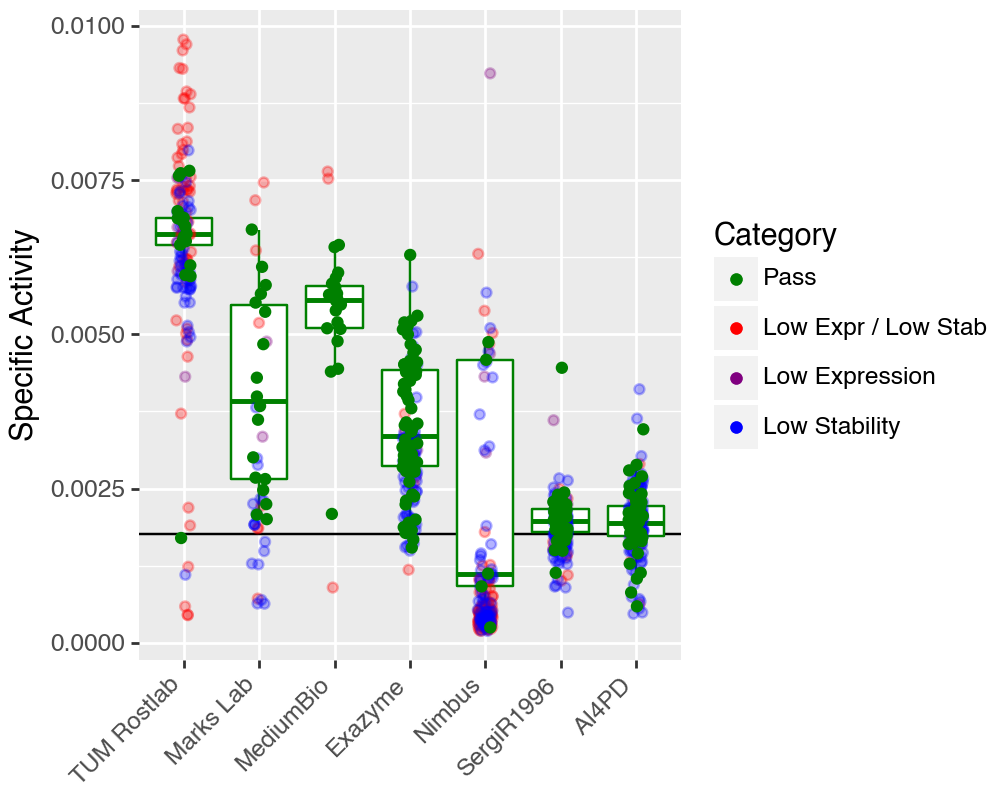

In [82]:
nocont = dd.loc[lambda d: d.team != "control"]
p9.options.set_option("figure_size", (5, 4))
p4 = (
    p9.ggplot(nocont, p9.aes("team", "output", color="Category"))
    + p9.geom_hline(yintercept=cont_spec_act)
    + p9.geom_boxplot(
        data=nocont.loc[lambda d: d.Category == "Pass"],
        outlier_alpha=0,
        show_legend=False,
    )
    + p9.geom_jitter(
        mapping=p9.aes(color="Category"),
        width=0.1,
        alpha=0.3,
        data=nocont.loc[lambda d: d.Category == "Low Expr / Low Stab"],
    )
    + p9.geom_jitter(
        mapping=p9.aes(color="Category"),
        width=0.1,
        alpha=0.3,
        data=nocont.query("Category == 'Low Expression'"),
    )
    + p9.geom_jitter(
        mapping=p9.aes(color="Category"),
        width=0.1,
        alpha=0.3,
        data=nocont.query("Category == 'Low Stability'"),
    )
    + p9.geom_jitter(
        mapping=p9.aes(color="Category"),
        width=0.1,
        data=nocont.query("Category == 'Pass'"),
    )
    + p9.ylab("Specific Activity")
    + p9.theme(
        axis_text_x=p9.element_text(angle=45, ha="right"),
    )
    + p9.xlab("")
    + p9.theme(legend_position=None)
    + p9.scale_color_manual(
        {
            "Pass": "green",
            "Low Expr / Low Stab": "red",
            "Low Expression": "purple",
            "Low Stability": "blue",
        }
    )
    + p9.guides(color=p9.guide_legend(title="Category"))
)
p4

In [83]:
p4.draw(show=False).savefig("../doc/invitro-overall-plot.png", dpi=150)

In [84]:
board = (
    nocont.loc[lambda d: (d.Category == "Pass")]
    .groupby("team", observed=False)
    .agg(
        max=pd.NamedAgg(column="output", aggfunc="max"),
        median=pd.NamedAgg(column="output", aggfunc="median"),
        number_pass=pd.NamedAgg(column="sequence", aggfunc="nunique"),
    )
    .dropna()
)
board

,max,median,number_pass
team,,,
TUM Rostlab,0.007651,0.006630,17
Marks Lab,0.006698,0.003915,18
MediumBio,0.006449,0.005551,20
Exazyme,0.006287,0.003360,72
Nimbus,0.004874,0.001123,5
SergiR1996,0.004458,0.001974,40
AI4PD,0.003461,0.001941,47


In [85]:
board.to_csv("../doc/invitro-board.csv")

### Ranks

Teams were requested to sequences ranked? Is there any information in those ranks? When there is, it would speak in favor of the generation method. We should look for sequences that pass criteria to be more highly ranked than those that do not.

In [86]:
ranks = (
    pd.read_csv("input/pet_invitro_submissions.csv")
    .rename(columns={"team/individual": "team", "Sequences": "sequence"})
    .drop_duplicates(subset=["team", "sequence"])
    .groupby("team")
    .apply(lambda d: d.assign(rank=list(range(len(d.sequence)))), include_groups=False)
    .reset_index()
    .assign(team=lambda d: d.team.replace(team_names))
    .drop(columns=["level_1"])
)

In [87]:
ranks.team.unique()

array(['MediumBio', 'SergiR1996', 'AI4PD', 'Exazyme', 'Marks Lab',
       'Nimbus', 'TUM Rostlab'], dtype=object)

In [88]:
cmp = (
    nocont[["team", "Category", "sequence", "output"]]
    .assign(good=lambda d: (d["Category"] == "Pass") & (d["output"] > cont_spec_act))
    .merge(ranks, how="left", on=["team", "sequence"], validate="1:1")
)

In [89]:
roc_ = []
for team, group in cmp.groupby("team"):
    rr = list(group["rank"].values)
    fpr, tpr, _ = roc_curve(group["good"], rr)
    roc_.append(pd.DataFrame({"fpr": fpr, "tpr": tpr, "team": team}))
roc = pd.concat(roc_)

Highly ranked sequences are better for several of the teams. We classified sequences as passing all criteria on stability, expression and specific activity and computed true/false positive rates at all cut-offs for the supplied ranks. The resulting receiver-operating-characteristic indicate that the information of the rank is low but non-zero for most teams.

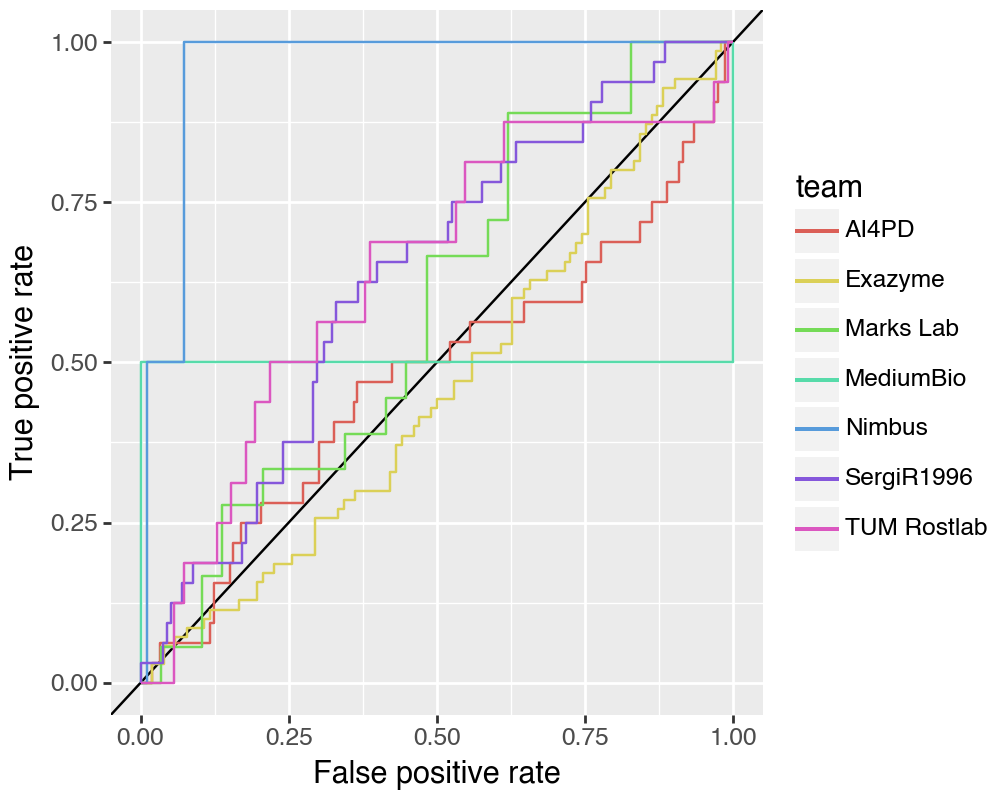

In [90]:
p = (
    p9.ggplot(roc, p9.aes("fpr", "tpr", color="team"))
    + p9.geom_abline()
    + p9.geom_line()
    + p9.ylab("True positive rate")
    + p9.xlab("False positive rate")
)
p

In [91]:
p.draw(show=False).savefig("../doc/invitro-roc.png", dpi=150)